<a href="https://colab.research.google.com/github/03chrisk/PEFT-T5-on-CNN-dailynews/blob/main/Monkey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from huggingface_hub import notebook_login

notebook_login() #u need my token for that, ask on dms as its private

In [ ]:
!pip install datasets
!pip install transformers datasets evaluate rouge_score
!pip install transformers datasets torch

In [ ]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

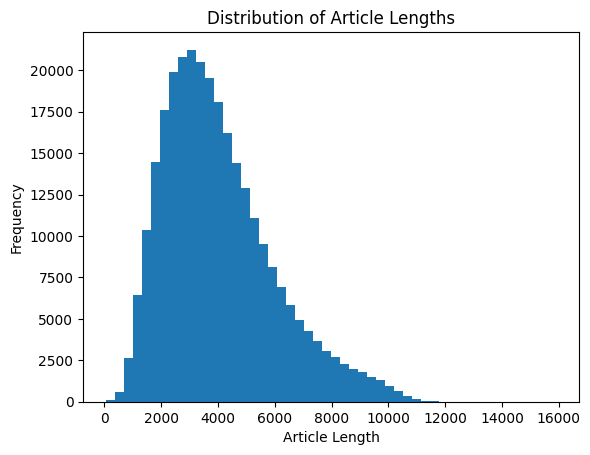

In [ ]:
import matplotlib.pyplot as plt

article_lengths = [len(article) for article in ds['train']['article']]

plt.hist(article_lengths, bins=50)
plt.xlabel('Article Length')
plt.ylabel('Frequency')
plt.title('Distribution of Article Lengths')
plt.show()

In [ ]:
ds['train']['article'][0]

'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details o

In [ ]:
ds['train'][0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

Some stuff from tutorial (no fine tuning)

In [ ]:
from transformers import pipeline
import torch

model_name = "t5-small" # or gpt-2, facebook/barg-large-cnn, etc.
revision = "main"  # or a specific commit hash, version, or tag

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

summarizer = pipeline("summarization", model=model_name, revision=revision, device=device)

text = "Machine learning is the study of computer algorithms that improve automatically through experience. It is seen as a part of artificial intelligence. Machine learning algorithms build a mathematical model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so."

summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
print(f"Summary: {summary[0]['summary_text']}")

NameError: name '_C' is not defined

Tutorial fine-tuning + hugginface guide


In [ ]:
#train_dataset = ds["train"].shuffle(seed=42).select(range(100))  # Using a subset for quick fine-tuning
#test_dataset = ds["test"].shuffle(seed=42).select(range(100))
train_dataset = ds["train"].select(range(100))
test_dataset = ds["test"].select(range(100))

In [ ]:
from transformers import AutoTokenizer

model_name = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

prefix = "summarize: " #PROMPTING

def tokenize_function(examples):
    #return tokenizer(examples['article'], padding="max_length", truncation=True)
    inputs = [prefix + article for article in examples['article']]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples['highlights'], max_length=128, truncation=True)

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)



NameError: name '_C' is not defined

In [ ]:
tokenized_train[0]

In [ ]:
len(tokenized_train[0]['input_ids'])  - len(tokenized_train['article'][0].split()) # no clue what that means yet

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [ ]:
import evaluate
rouge = evaluate.load("rouge")

In [ ]:
#model.save_pretrained("./fine-tuned-model")
#tokenizer.save_pretrained("./fine-tuned-model")